# Bank Project - Classification Model Fitting

In [1]:
#!pip install imblearn

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

import preprocessing as prep

from matplotlib.pyplot import cm
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support, precision_score, make_scorer
prec_scorer = make_scorer(precision_score)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Fetch Data

In [3]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

In [4]:
ct = ColumnTransformer(
    [("target",prep.TargetTransformer(),'y')])

y_trans = pd.DataFrame(data = ct.fit_transform(df),columns=['y_trans'] ,index = df.index)

df_t = pd.concat([y_trans,df],axis=1).drop(['y'],axis=1)

In [5]:
train = df_t.sample(n=int(len(df_t)*0.75), random_state=101)
test = df_t[~df_t.index.isin(train.index)]

## Undersamping, Oversampling, & SMOTE Sampling

In [6]:
# Upsample minority classPython

# Separate majority and minority classes
df_majority = train[train.y_trans==0]
df_minority = train[train.y_trans==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=1)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([df_majority, df_minority_upsampled])

#
X_train_upsampled = train_upsampled.drop(['y_trans'],axis=1)
y_train_upsampled = train_upsampled.y_trans

# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False,n_samples=len(df_minority),random_state=101)

# Combine majority class with upsampled minority class
train_downsampled = pd.concat([df_minority, df_majority_downsampled])

#
X_train_downsampled = train_downsampled.drop(['y_trans'],axis=1)
y_train_downsampled = train_downsampled.y_trans


# SMOTE

sm = SMOTE(sampling_strategy = 0.25, random_state=101)

cat_features = ['job','marital','education','default','housing','loan','contact','poutcome','month']

ct = ColumnTransformer(
    [
    ("logplus1",prep.LogPlus1Transformer(),['duration','age']),
    ("campaign",prep.CampaignTransformer(),'campaign'),
    ("balance",prep.CampaignTransformer(),'balance'),
    ('ohe',OneHotEncoder(sparse=False),cat_features)
    ]
    )

X_smote, y_smote = sm.fit_resample(ct.fit_transform(train.drop(['y_trans'],axis=1)), train.y_trans)

# No Sampling Strategy

In [7]:

X_train, X_test, y_train, y_test = train.drop(['y_trans'],axis=1), test.drop(['y_trans'],axis=1), train.y_trans, test.y_trans

lreg = LogisticRegression(max_iter=1000).fit(ct.fit_transform(X_train),y_train)

# Under-sampling Strategy

In [8]:
lreg_under = LogisticRegression(max_iter=1000).fit(ct.fit_transform(X_train_downsampled),y_train_downsampled)

# Over-sampling Strategy

In [9]:
lreg_over = LogisticRegression(max_iter=1000).fit(ct.fit_transform(X_train_upsampled),y_train_upsampled)

# SMOTE Strategy

In [10]:
lreg_smote = LogisticRegression(max_iter=1000).fit(X_smote, y_smote)

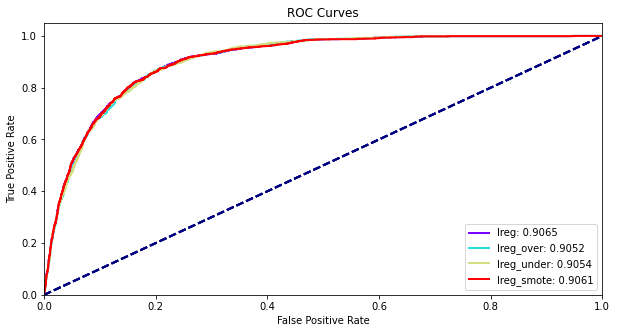

In [11]:
plt.figure(figsize=(10,5))

color=iter(cm.rainbow(np.linspace(0,1,4)))
model_dict = {'lreg':lreg,'lreg_over':lreg_over,'lreg_under':lreg_under, 'lreg_smote':lreg_smote}

for model in model_dict.keys():
    y_score = model_dict[model].predict_proba(ct.fit_transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color = next(color), label=model + ': %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [12]:
def pos_class_table(model, y_true, X):
    df = pd.DataFrame(precision_recall_fscore_support(y_true, model.predict(ct.transform(X)))).iloc[:,1]
    return(df)

In [13]:
result_df = pd.DataFrame(data = {'lreg': pos_class_table(lreg, y_test, X_test),
'lreg_under': pos_class_table(lreg_under, y_test, X_test),
'lreg_over': pos_class_table(lreg_over, y_test, X_test),
'lreg_smote': pos_class_table(lreg_smote, y_test, X_test)})
result_df.index = ['precision','recall','f1_score','support']
result_df

,lreg,lreg_under,lreg_over,lreg_smote
precision,0.646067,0.382245,0.386162,0.569510
recall,0.339734,0.842688,0.836780,0.532496
f1_score,0.445305,0.525928,0.528451,0.550382
support,1354.000000,1354.000000,1354.000000,1354.000000


In [14]:
acc_df = pd.DataFrame(data = {'lreg': lreg.score(ct.transform(X_test), y_test),
'lreg_under': lreg_under.score(ct.transform(X_test), y_test),
'lreg_over': lreg_over.score(ct.transform(X_test), y_test),
'lreg_smote': lreg_smote.score(ct.transform(X_test), y_test)},index = ['accuracy'])
acc_df

,lreg,lreg_under,lreg_over,lreg_smote
accuracy,0.898611,0.818013,0.821109,0.89578


In [15]:
print('Ratio of positive class: ' + str(np.round(y_test.value_counts()[1]/len(y_test),2)))
prediction_counts = pd.Series(lreg_smote.predict(X_smote)).value_counts()
print('Ratio of predicted positive class: ' + str(np.round(prediction_counts[1]/prediction_counts[0],2)))

Ratio of positive class: 0.12
Ratio of predicted positive class: 0.18


**Notes**

A sampling strategy using SMOTE with a ratio of 1 positive class labels to 4 negative class labels looks like a good strategy. That would give a good balance of classification metrics. Compared to creating balanced classes, we can see that fitting a Logistic Regression model on balanced classes did not give us the metrics we wanted for precision, but did better for recall. Depending on what we want from the model, we can pick either the SMOTE approach or the oversampling approach.

# END